In [ ]:
# !cp /kaggle/input/data-bowl-2019-external-data/*.py /kaggle/working

In [1]:
%reload_ext autoreload
%autoreload 2
import warnings
import jupytools.syspath
def ignore(*args, **kwargs): pass
warnings.warn = ignore
jupytools.syspath.add('..')

In [2]:
from functools import partial

import numpy as np
import pandas as pd
from IPython.display import display

import bundle
import features as F
import selection
import utils as U
from dataset import load, load_sample, Subset
from encode import encode
from training import train, inference, submit
from meta import compute_meta_data
from metric import optimize_rounding_bounds, RegressionCappa

In [3]:
sample = False
if U.on_kaggle():
    U.log('Loading test set only.')
    tst_data = pd.read_csv('/kaggle/input/data-science-bowl-2019/test.csv')
else:
    if sample:
        U.log('Warning: loading train and test data sample.')
        trn_data, _, _ = load_sample(Subset.Train, 500_000)
        [tst_data] = load_sample(Subset.Test, 500_000)
    else:
        U.log('Loading train and test.')
        trn_data, trn_spec, trn_targ = load(Subset.Train)
        [tst_data] = load(Subset.Test)

Loading train and test.
(11341042, 11) (17690, 7) (386, 3) (1156414, 11) 

## Preparing

In [4]:
transform = U.combine(
    partial(F.add_feature_combinations, pairs=[('title', 'event_code')]),
    partial(F.add_datetime, column='timestamp', prefix='ts'),
    partial(F.add_cyclical, prefix='ts')
)

if U.on_kaggle():
    U.log('Transforming test data only.')
    X_tst = transform(tst_data.copy())
    U.log(X_tst.shape)
else:
    U.log('Transforming train and test data.')
    X_tst = transform(tst_data.copy())
    X_trn = transform(trn_data.copy())
    U.log(X_trn.shape, X_tst.shape)

Transforming train and test data.
(11341042, 31) (1156414, 31)


In [5]:
if U.on_kaggle():
    U.log('Reading pre-computed meta from disk.')
    meta = bundle.meta()
else:
    U.log('Computing meta using train and test datasets.')
    meta = compute_meta_data(X_trn, X_tst)
    U.log('Saving computed meta on disk.')
    bundle.save_meta(meta, 'meta')

Computing meta using train and test datasets.
Saving computed meta on disk.


In [6]:
extractor = F.FeaturesExtractor([
    F.CountingFeatures(meta),
    F.PerformanceFeatures(meta),
    F.CyclicFeatures(meta),
    F.TimestampFeatures(meta),
    F.VarietyFeatures(meta),
    F.EventDataFeatures(meta)
])

algo = F.InMemoryAlgorithm(extractor, meta, num_workers=12)

cat_cols = ['session_title']

if U.on_kaggle():
    U.log('Preparing test dataset.')
    X_tst = algo.run(X_tst, test=True)
    encoders = bundle.encoders()
    X_tst, _ = encode(X_tst, cat_cols, encoders=encoders)
else:
    U.log('Preparing train and test datasets.')
    X_trn = algo.run(X_trn)
    X_tst = algo.run(X_tst, test=True)
    X_trn, encoders = encode(X_trn, cat_cols)
    X_tst, _ = encode(X_tst, cat_cols, encoders=encoders)
    bundle.save(encoders, 'encoders')

Preparing train and test datasets.
Running algorithm in train mode.



Running algorithm in test mode.


In [7]:
if U.on_kaggle():
    U.log('Running post-processing on test set only.')
    F.add_user_wise_features(X_tst, meta)
else:
    U.log('Running post-processing on train and test sets.')
    F.add_user_wise_features(X_trn, meta)
    F.add_user_wise_features(X_tst, meta)

Running post-processing on train and test sets.


In [76]:
from collections import Counter
from sklearn.metrics import cohen_kappa_score

def round_regression_predictions(y_true, y_pred):
    dist = Counter(y_true)
    size = len(y_true)
    norm = {k:v/size for k, v in dist.items()}
    acc, bounds = 0, []
    for i in range(3):
        acc += norm[i]
        bounds.append(np.percentile(y_pred, acc*100))
    rounded = pd.cut(y_pred, [-np.inf] + sorted(bounds) + [np.inf], labels=[0, 1, 2, 3])
    return rounded, bounds

def cappa(y_true, y_pred):
    y_pred_rounded, _ = round_regression_predictions(y_true, y_pred)
    score = cohen_kappa_score(y_true, y_pred_rounded, weights='quadratic')
    return score

## Experiments

In [11]:
features = [c for c in X_trn.columns 
            if c not in ('installation_id', 'game_session', 'accuracy_group')]

In [52]:
from sklearn.model_selection import GroupKFold
from training import EnsembleTrainer, get_default_config
model_type = 'lightgbm'
trainer = EnsembleTrainer(algo=model_type, cv_metrics={'cappa': cappa})
fold = GroupKFold(n_splits=5)
config = get_default_config(model_type)
# U.set_nested(config, 'model_params.n_estimators', 10000)
result = trainer.train(X_trn, features=features, fold=fold, config=config)

Running k-fold 1 of 5
Training until validation scores don't improve for 100 rounds.
[100]	trn's rmse: 1.03326	val's rmse: 1.04923
[200]	trn's rmse: 0.962989	val's rmse: 0.999547
[300]	trn's rmse: 0.926332	val's rmse: 0.983791
[400]	trn's rmse: 0.899491	val's rmse: 0.976364
[500]	trn's rmse: 0.877334	val's rmse: 0.972621
[600]	trn's rmse: 0.857882	val's rmse: 0.971365
[700]	trn's rmse: 0.840059	val's rmse: 0.970448
[800]	trn's rmse: 0.823654	val's rmse: 0.969884
[900]	trn's rmse: 0.808374	val's rmse: 0.969935
Early stopping, best iteration is:
[860]	trn's rmse: 0.814261	val's rmse: 0.969637
Running k-fold 2 of 5
Training until validation scores don't improve for 100 rounds.
[100]	trn's rmse: 1.03263	val's rmse: 1.06254
[200]	trn's rmse: 0.961327	val's rmse: 1.01157
[300]	trn's rmse: 0.924617	val's rmse: 0.994396
[400]	trn's rmse: 0.898249	val's rmse: 0.987712
[500]	trn's rmse: 0.876369	val's rmse: 0.984182
[600]	trn's rmse: 0.857279	val's rmse: 0.981476
[700]	trn's rmse: 0.839928	val's

In [ ]:
# def eval_qwk_lgb_regr(y_pred, train_t):
#     """
#     Fast cappa eval function for lgb.
#     """
#     dist = Counter(train_t['accuracy_group'])
#     for k in dist:
#         dist[k] /= len(train_t)
    
#     acum = 0
#     bound = {}
#     for i in range(3):
#         acum += dist[i]
#         bound[i] = np.percentile(y_pred, acum * 100)

#     def classify(x):
#         if x <= bound[0]:
#             return 0
#         elif x <= bound[1]:
#             return 1
#         elif x <= bound[2]:
#             return 2
#         else:
#             return 3

#     y_pred = np.array(list(map(classify, y_pred)))
    
#     return y_pred

In [15]:
# features from event_data
# https://www.kaggle.com/c/data-science-bowl-2019/discussion/124028

# truncated validation
# https://www.kaggle.com/ragnar123/truncated-val
# https://www.kaggle.com/c/data-science-bowl-2019/discussion/120790

# def eval_qwk_lgb_regr(y_pred, train_t):
#     """
#     Fast cappa eval function for lgb.
#     """
#     dist = Counter(train_t['accuracy_group'])
#     for k in dist:
#         dist[k] /= len(train_t)
    
#     acum = 0
#     bound = {}
#     for i in range(3):
#         acum += dist[i]
#         bound[i] = np.percentile(y_pred, acum * 100)

#     def classify(x):
#         if x <= bound[0]:
#             return 0
#         elif x <= bound[1]:
#             return 1
#         elif x <= bound[2]:
#             return 2
#         else:
#             return 3

#     y_pred = np.array(list(map(classify, y_pred)))
    
#     return y_pred

# from sklearn.metrics import cohen_kappa_score, mean_squared_error

#     params = {'boosting_type': 'gbdt', 
#               'metric': 'rmse', 
#               'objective': 'regression', 
#               'eval_metric': 'cappa', 
#               'n_jobs': -1, 
#               'seed': 42, 
#               'num_leaves': 26, 
#               'learning_rate': 0.077439684887749, 
#               'max_depth': 33, 
#               'lambda_l1': 3.27791989030057, 
#               'lambda_l2': 1.3047627805931334, 
#               'bagging_fraction': 0.896924978584253, 
#               'bagging_freq': 1, 
#               'colsample_bytree': 0.8710772167017853}

# https://www.kaggle.com/braquino/convert-to-regression

In [54]:
def match_cols(cols, regex):
    import re
    return [col for col in cols if re.match(regex, col)]
def starts_with(cols, prefix): 
    return match_cols(cols, f'^{prefix}')

In [63]:
from collections import OrderedDict

columns = X_trn.columns.tolist()
cnt_cols = starts_with(columns, 'cnt_')
perf_cols = starts_with(columns, 'perf_')
var_cols = starts_with(columns, 'var_')
user_cols = starts_with(columns, 'user_')
ts_cols = starts_with(columns, 'ts_')
event_cols = starts_with(columns, 'event_')
cat_cols = ['session_title']
cols = cnt_cols + perf_cols + var_cols + user_cols + ts_cols + event_cols + cat_cols

features_groups = [
    ('all', cols),
    ('cnt', cnt_cols),
    ('perf', perf_cols),
    ('var', var_cols),
    ('user', user_cols),
    ('ts', ts_cols),
    ('cnt+perf', cnt_cols + perf_cols),
    ('cnt+var', cnt_cols + var_cols),
    ('cnt+ts', cnt_cols + ts_cols),
    ('perf+var', perf_cols + var_cols),
    ('perf+ts', perf_cols + ts_cols),
    ('cnt+user', cnt_cols + user_cols),
    ('cnt+perf+var', cnt_cols + perf_cols + var_cols),
    ('cnt+perf+user', cnt_cols + perf_cols + user_cols),
    ('cnt+perf+user+var', cnt_cols + perf_cols + user_cols + var_cols),
    ('cnt+perf+cat', cnt_cols + perf_cols + cat_cols),
    ('event', event_cols),
    ('event+cnt', event_cols + cnt_cols),
    ('event+cnt+perf', event_cols + cnt_cols + perf_cols),
    ('event+cnt+perf+user', event_cols + cnt_cols + perf_cols + user_cols),
    ('event+cnt+perf+var', event_cols + cnt_cols + perf_cols + var_cols),
    ('event+cnt+perf+user+var', event_cols + cnt_cols + perf_cols + user_cols + var_cols),
    ('event+cnt+pert+cat', event_cols + cnt_cols + perf_cols + cat_cols),
    ('all-ts', [c for c in cols if c not in ts_cols]),
    ('all-ts-event', [c for c in cols if c not in ts_cols and c not in event_cols])
]

In [64]:
from sklearn.model_selection import GroupKFold
from training import EnsembleTrainer, get_default_config

model_type = 'lightgbm'
trainer = EnsembleTrainer(algo=model_type, cv_metrics={'cappa': cappa})
fold = GroupKFold(n_splits=5)
config = get_default_config(model_type)
U.set_nested(config, 'model_params.feature_fraction', 0.8)
U.set_nested(config, 'model_params.bagging_fraction', 0.75)
U.set_nested(config, 'model_params.bagging_freq', 1)

results = []
for col_group, features in features_groups:
    U.log(f'Training columns group: {col_group}')
    result = trainer.train(X_trn, features=features, fold=fold, config=config)
    results.append((col_group, result))

Training columns group: all
Running k-fold 1 of 5
Training until validation scores don't improve for 100 rounds.
[100]	trn's rmse: 1.04089	val's rmse: 1.06139
[200]	trn's rmse: 0.964845	val's rmse: 1.00376
[300]	trn's rmse: 0.92666	val's rmse: 0.985192
[400]	trn's rmse: 0.899951	val's rmse: 0.977373
[500]	trn's rmse: 0.878463	val's rmse: 0.974021
[600]	trn's rmse: 0.859595	val's rmse: 0.972114
[700]	trn's rmse: 0.842434	val's rmse: 0.972288
Early stopping, best iteration is:
[613]	trn's rmse: 0.857273	val's rmse: 0.97197
Running k-fold 2 of 5
Training until validation scores don't improve for 100 rounds.
[100]	trn's rmse: 1.03798	val's rmse: 1.06869
[200]	trn's rmse: 0.963251	val's rmse: 1.01237
[300]	trn's rmse: 0.925632	val's rmse: 0.993946
[400]	trn's rmse: 0.899402	val's rmse: 0.986038
[500]	trn's rmse: 0.878148	val's rmse: 0.982115
[600]	trn's rmse: 0.859621	val's rmse: 0.980047
[700]	trn's rmse: 0.842679	val's rmse: 0.97853
[800]	trn's rmse: 0.827164	val's rmse: 0.978037
[900]	tr

Running k-fold 2 of 5
Training until validation scores don't improve for 100 rounds.
[100]	trn's rmse: 1.22593	val's rmse: 1.25059
[200]	trn's rmse: 1.21317	val's rmse: 1.24805
[300]	trn's rmse: 1.20464	val's rmse: 1.24689
[400]	trn's rmse: 1.19804	val's rmse: 1.24682
Early stopping, best iteration is:
[338]	trn's rmse: 1.20196	val's rmse: 1.24662
Running k-fold 3 of 5
Training until validation scores don't improve for 100 rounds.
[100]	trn's rmse: 1.23303	val's rmse: 1.22379
[200]	trn's rmse: 1.22037	val's rmse: 1.2209
[300]	trn's rmse: 1.21198	val's rmse: 1.22043
[400]	trn's rmse: 1.20528	val's rmse: 1.21984
[500]	trn's rmse: 1.19938	val's rmse: 1.21991
Early stopping, best iteration is:
[454]	trn's rmse: 1.20203	val's rmse: 1.21974
Running k-fold 4 of 5
Training until validation scores don't improve for 100 rounds.
[100]	trn's rmse: 1.22667	val's rmse: 1.25192
[200]	trn's rmse: 1.21424	val's rmse: 1.25028
[300]	trn's rmse: 1.20578	val's rmse: 1.2505
Early stopping, best iteration is

[700]	trn's rmse: 0.988905	val's rmse: 1.1409
[800]	trn's rmse: 0.975165	val's rmse: 1.14096
Early stopping, best iteration is:
[743]	trn's rmse: 0.982948	val's rmse: 1.14042
Running k-fold 3 of 5
Training until validation scores don't improve for 100 rounds.
[100]	trn's rmse: 1.15173	val's rmse: 1.15685
[200]	trn's rmse: 1.10364	val's rmse: 1.1322
[300]	trn's rmse: 1.07253	val's rmse: 1.12191
[400]	trn's rmse: 1.04931	val's rmse: 1.11674
[500]	trn's rmse: 1.02982	val's rmse: 1.11448
[600]	trn's rmse: 1.01265	val's rmse: 1.11281
[700]	trn's rmse: 0.997345	val's rmse: 1.11136
[800]	trn's rmse: 0.983494	val's rmse: 1.11161
Early stopping, best iteration is:
[701]	trn's rmse: 0.997194	val's rmse: 1.11132
Running k-fold 4 of 5
Training until validation scores don't improve for 100 rounds.
[100]	trn's rmse: 1.14692	val's rmse: 1.17983
[200]	trn's rmse: 1.09799	val's rmse: 1.15292
[300]	trn's rmse: 1.06717	val's rmse: 1.14116
[400]	trn's rmse: 1.04339	val's rmse: 1.13524
[500]	trn's rmse: 1.

[200]	trn's rmse: 1.14435	val's rmse: 1.19781
[300]	trn's rmse: 1.12099	val's rmse: 1.19472
Early stopping, best iteration is:
[292]	trn's rmse: 1.1226	val's rmse: 1.19448
Running k-fold 5 of 5
Training until validation scores don't improve for 100 rounds.
[100]	trn's rmse: 1.17273	val's rmse: 1.21521
[200]	trn's rmse: 1.1391	val's rmse: 1.20777
[300]	trn's rmse: 1.11555	val's rmse: 1.2062
[400]	trn's rmse: 1.09649	val's rmse: 1.20652
Early stopping, best iteration is:
[318]	trn's rmse: 1.11178	val's rmse: 1.20589
Fold evaluation results:
cv_cappa_1=0.3045, cv_cappa_2=0.2765, cv_cappa_3=0.2831, cv_cappa_4=0.2911, cv_cappa_5=0.2634
Training columns group: cnt+user
Running k-fold 1 of 5
Training until validation scores don't improve for 100 rounds.
[100]	trn's rmse: 1.14474	val's rmse: 1.175
[200]	trn's rmse: 1.09328	val's rmse: 1.14879
[300]	trn's rmse: 1.06002	val's rmse: 1.13681
[400]	trn's rmse: 1.03484	val's rmse: 1.12955
[500]	trn's rmse: 1.01438	val's rmse: 1.12492
[600]	trn's rms

[100]	trn's rmse: 1.14107	val's rmse: 1.17034
[200]	trn's rmse: 1.09183	val's rmse: 1.14222
[300]	trn's rmse: 1.05922	val's rmse: 1.1305
[400]	trn's rmse: 1.03414	val's rmse: 1.12416
[500]	trn's rmse: 1.01263	val's rmse: 1.12094
[600]	trn's rmse: 0.993718	val's rmse: 1.11919
[700]	trn's rmse: 0.976517	val's rmse: 1.11827
[800]	trn's rmse: 0.960546	val's rmse: 1.11755
[900]	trn's rmse: 0.945955	val's rmse: 1.1176
Early stopping, best iteration is:
[881]	trn's rmse: 0.948642	val's rmse: 1.11736
Running k-fold 5 of 5
Training until validation scores don't improve for 100 rounds.
[100]	trn's rmse: 1.13549	val's rmse: 1.18596
[200]	trn's rmse: 1.08547	val's rmse: 1.16317
[300]	trn's rmse: 1.05276	val's rmse: 1.15257
[400]	trn's rmse: 1.02755	val's rmse: 1.14728
[500]	trn's rmse: 1.00633	val's rmse: 1.14403
[600]	trn's rmse: 0.987617	val's rmse: 1.1425
[700]	trn's rmse: 0.970591	val's rmse: 1.14192
[800]	trn's rmse: 0.954917	val's rmse: 1.14195
Early stopping, best iteration is:
[707]	trn's 

Running k-fold 3 of 5
Training until validation scores don't improve for 100 rounds.
[100]	trn's rmse: 1.19917	val's rmse: 1.19985
[200]	trn's rmse: 1.16835	val's rmse: 1.18802
[300]	trn's rmse: 1.14655	val's rmse: 1.18229
[400]	trn's rmse: 1.12901	val's rmse: 1.17916
[500]	trn's rmse: 1.1135	val's rmse: 1.17783
[600]	trn's rmse: 1.09946	val's rmse: 1.1771
[700]	trn's rmse: 1.0863	val's rmse: 1.17612
[800]	trn's rmse: 1.07376	val's rmse: 1.17542
Early stopping, best iteration is:
[778]	trn's rmse: 1.0766	val's rmse: 1.1753
Running k-fold 4 of 5
Training until validation scores don't improve for 100 rounds.
[100]	trn's rmse: 1.1938	val's rmse: 1.23141
[200]	trn's rmse: 1.16274	val's rmse: 1.22082
[300]	trn's rmse: 1.14068	val's rmse: 1.21657
[400]	trn's rmse: 1.1226	val's rmse: 1.21367
[500]	trn's rmse: 1.10695	val's rmse: 1.21222
[600]	trn's rmse: 1.09263	val's rmse: 1.21109
[700]	trn's rmse: 1.07944	val's rmse: 1.21095
[800]	trn's rmse: 1.06691	val's rmse: 1.21068
[900]	trn's rmse: 1.

Training until validation scores don't improve for 100 rounds.
[100]	trn's rmse: 1.13696	val's rmse: 1.17124
[200]	trn's rmse: 1.08141	val's rmse: 1.14026
[300]	trn's rmse: 1.04411	val's rmse: 1.12469
[400]	trn's rmse: 1.01561	val's rmse: 1.11558
[500]	trn's rmse: 0.991963	val's rmse: 1.10981
[600]	trn's rmse: 0.971513	val's rmse: 1.10738
[700]	trn's rmse: 0.952577	val's rmse: 1.10607
[800]	trn's rmse: 0.935143	val's rmse: 1.10477
[900]	trn's rmse: 0.919181	val's rmse: 1.10405
[1000]	trn's rmse: 0.904241	val's rmse: 1.1036
Early stopping, best iteration is:
[984]	trn's rmse: 0.906663	val's rmse: 1.10342
Running k-fold 2 of 5
Training until validation scores don't improve for 100 rounds.
[100]	trn's rmse: 1.13491	val's rmse: 1.17527
[200]	trn's rmse: 1.08102	val's rmse: 1.14389
[300]	trn's rmse: 1.04447	val's rmse: 1.12632
[400]	trn's rmse: 1.01617	val's rmse: 1.11749
[500]	trn's rmse: 0.992976	val's rmse: 1.11192
[600]	trn's rmse: 0.972767	val's rmse: 1.10841
[700]	trn's rmse: 0.954793

Early stopping, best iteration is:
[837]	trn's rmse: 0.935381	val's rmse: 1.07726
Running k-fold 4 of 5
Training until validation scores don't improve for 100 rounds.
[100]	trn's rmse: 1.13482	val's rmse: 1.16741
[200]	trn's rmse: 1.07868	val's rmse: 1.13536
[300]	trn's rmse: 1.04179	val's rmse: 1.12095
[400]	trn's rmse: 1.01337	val's rmse: 1.11346
[500]	trn's rmse: 0.99003	val's rmse: 1.10918
[600]	trn's rmse: 0.969477	val's rmse: 1.10765
[700]	trn's rmse: 0.950698	val's rmse: 1.10658
[800]	trn's rmse: 0.933566	val's rmse: 1.106
[900]	trn's rmse: 0.91762	val's rmse: 1.10555
[1000]	trn's rmse: 0.902462	val's rmse: 1.10564
Early stopping, best iteration is:
[952]	trn's rmse: 0.909554	val's rmse: 1.1054
Running k-fold 5 of 5
Training until validation scores don't improve for 100 rounds.
[100]	trn's rmse: 1.13004	val's rmse: 1.18338
[200]	trn's rmse: 1.07499	val's rmse: 1.15559
[300]	trn's rmse: 1.03786	val's rmse: 1.14156
[400]	trn's rmse: 1.00911	val's rmse: 1.13426
[500]	trn's rmse: 0.

[500]	trn's rmse: 0.885807	val's rmse: 0.971642
[600]	trn's rmse: 0.868565	val's rmse: 0.969443
[700]	trn's rmse: 0.852862	val's rmse: 0.968576
[800]	trn's rmse: 0.838688	val's rmse: 0.968421
[900]	trn's rmse: 0.825369	val's rmse: 0.968266
Early stopping, best iteration is:
[886]	trn's rmse: 0.827159	val's rmse: 0.968112
Running k-fold 2 of 5
Training until validation scores don't improve for 100 rounds.
[100]	trn's rmse: 1.03802	val's rmse: 1.06812
[200]	trn's rmse: 0.965959	val's rmse: 1.0131
[300]	trn's rmse: 0.929452	val's rmse: 0.993549
[400]	trn's rmse: 0.905029	val's rmse: 0.985297
[500]	trn's rmse: 0.885358	val's rmse: 0.980793
[600]	trn's rmse: 0.868482	val's rmse: 0.978669
[700]	trn's rmse: 0.853063	val's rmse: 0.977542
[800]	trn's rmse: 0.839075	val's rmse: 0.977109
[900]	trn's rmse: 0.825973	val's rmse: 0.976893
[1000]	trn's rmse: 0.813654	val's rmse: 0.976411
[1100]	trn's rmse: 0.801876	val's rmse: 0.976776
Early stopping, best iteration is:
[1000]	trn's rmse: 0.813654	val

In [65]:
report = pd.DataFrame([
    OrderedDict([('features', name)] + list(result.cv.items())) 
    for name, result in results])
cappa_cols = starts_with(report.columns, 'cv_cappa')
report['mean'] = report[cappa_cols].mean(axis=1)
report['std'] = report[cappa_cols].std(axis=1)
report.sort_values(by=['mean'], inplace=True, ascending=False)
report.reset_index(drop=True, inplace=True)
report.to_csv(f'report_{U.now()}.csv', index=False)

In [66]:
def highlight_best(col):
    if not col.name.startswith('cv_cappa_'):
        return [''] * len(col)
    is_best = col.index == col.argmax()
    return ['background-color: salmon' if idx else '' for idx in is_best]

In [67]:
report.style.apply(highlight_best)

,features,cv_cappa_1,cv_cappa_2,cv_cappa_3,cv_cappa_4,cv_cappa_5,mean,std
0,all-ts,0.613216,0.615561,0.596259,0.58267,0.579315,0.597404,0.0167726
1,all-ts-event,0.608946,0.615915,0.592547,0.585863,0.567245,0.594103,0.0192858
2,all,0.610369,0.610773,0.588092,0.581251,0.57541,0.593179,0.0164995
3,event+cnt+pert+cat,0.602007,0.603502,0.581224,0.573802,0.569907,0.586089,0.0157568
4,cnt+perf+cat,0.603609,0.600843,0.580295,0.572561,0.566002,0.584662,0.016841
5,event+cnt+perf+user,0.461811,0.455969,0.457038,0.446989,0.404829,0.445327,0.0232649
6,event+cnt+perf+user+var,0.461456,0.455259,0.451284,0.448053,0.406959,0.444602,0.0216287
7,event+cnt+perf+var,0.444554,0.442669,0.440518,0.429962,0.387256,0.428992,0.0240049
8,event+cnt+perf,0.439039,0.445211,0.439589,0.430089,0.389918,0.428769,0.0223831
9,event+cnt,0.438505,0.432739,0.420284,0.431027,0.379268,0.420364,0.0238998


In [151]:
import json
sample = trn_data.sample(1_000_000)
event_data = pd.io.json.json_normalize(sample.event_data.apply(json.loads))

In [153]:
from dataset import existing_info
stat_info = existing_info(event_data).T.reset_index()

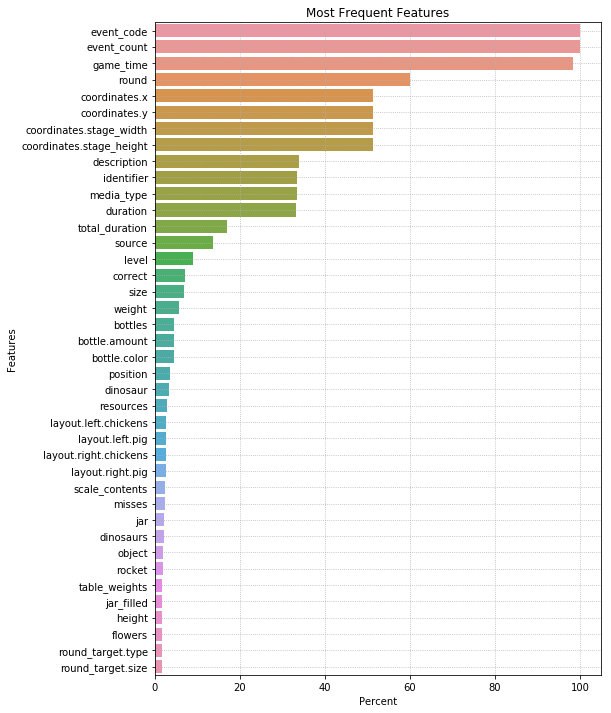

In [157]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
f, ax = plt.subplots(figsize=(8, 12))
ax = sns.barplot(x='Percent', y='index', data=stat_info.head(40))
ax.set_title('Most Frequent Features')
ax.set_ylabel('Features')
ax.grid(True, linestyle='dotted')

In [171]:
freq_keys = stat_info['index'][stat_info['Percent'] >= 5.].tolist()

In [172]:
freq_keys

['event_code',
 'event_count',
 'game_time',
 'round',
 'coordinates.x',
 'coordinates.y',
 'coordinates.stage_width',
 'coordinates.stage_height',
 'description',
 'identifier',
 'media_type',
 'duration',
 'total_duration',
 'source',
 'level',
 'correct',
 'size',
 'weight']

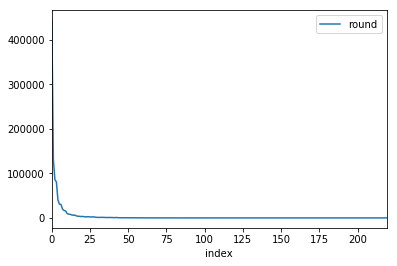

In [246]:
round_df = event_data['round'].fillna(0).value_counts().reset_index()
round_df['index'] = round_df['index'].astype(int)
round_df.sort_values(by='index', inplace=True)
round_df.plot(x='index', y='round')

In [251]:
np.isnan(event_data['coordinates.x'].iloc[3])

True

In [248]:
event_data['coordinates.x'].fillna(0)

0         954.0
1         393.0
2           0.0
3           0.0
4           0.0
          ...  
999995    910.0
999996    752.0
999997    646.0
999998      0.0
999999    337.0
Name: coordinates.x, Length: 1000000, dtype: float64

In [266]:
event_data['media_type'].fillna('unknown').value_counts()

unknown      665828
animation    222336
audio        111836
Name: media_type, dtype: int64

In [234]:
# round: float with NaNs
# coordinates.(x|y): float with NaNs, but presumably integer
# coordinates.stage_(width|height): float with NaNs, but presumably categorical
#
# description: text messages, try to convert into categoricals?
#     (event_data['description'].fillna('n/a').value_counts()
#      .rename('count').reset_index().rename(columns={'index': 'text'}))
#
# identifier: some string, probably concatenated with commas; most simple is to compute len
# event_data['identifier'].fillna('n/a').str.split(',').apply(len)
#
# media_type: categorical string
# event_data['media_type'].fillna('n/a').value_counts()
#
# duration: should already exist in the features set
# total_duration: probably also present in the features
#
# source: also some kind of categorical string
# event_data['source'].fillna('n/a').value_counts()
#
# level: integer feature, can be used as a cumulative metric (?)
# event_data['level'].fillna('n/a').value_counts()
#
# correct: defines if attempt was done, is already used in feature processing
# 
# size: integer feature
# event_data['size'].fillna('n/a').value_counts()
#
# weight: one more integer feature
# event_data['weight'].fillna('n/a').value_counts()

## Features Selection

In [21]:
# selector = selection.FeatureSelection(
#     rules=[
#         ('nonzero', selection.non_zero_rows_and_cols),
#         # ('uncorr', selection.non_correlated_cols),
#     ],
#     ignore_cols=[
#         'accuracy_group', 
#         'installation_id', 
#         'game_session'
#     ]
# )

# if U.on_kaggle():
#     U.log('Loading relevant features list from disk.')
#     features = bundle.features()
# else:
#     U.log('Deriving relevant features from train dataset.')
#     features = selector.select(X_trn)
#     bundle.save(features, 'features')

Deriving relevant features from train dataset.
Excluding from consideration: ['accuracy_group', 'installation_id', 'game_session']
Applying feature selection rule: nonzero
Selected features: 935 of 950
Keeping only features, selected by every rule.
Final number of features changed from 950 to 935


In [72]:
if U.on_kaggle():
    U.log('Loading relevant features list from disk.')
    features = bundle.features()
else:
    columns = X_trn.columns.tolist()
    cnt_cols = starts_with(columns, 'cnt_')
    perf_cols = starts_with(columns, 'perf_')
    var_cols = starts_with(columns, 'var_')
    user_cols = starts_with(columns, 'user_')
    ts_cols = starts_with(columns, 'ts_')
    event_cols = starts_with(columns, 'event_')
    cat_cols = ['session_title']
    features = cnt_cols + perf_cols + user_cols + event_cols + var_cols + cat_cols
    bundle.save(features, 'features')
U.log(f'Total number of features: {len(features)}')

Total number of features: 947


## Submission

In [78]:
algo = 'lightgbm'
version = '015'
trainer = EnsembleTrainer(algo=algo, cv_metrics={'cappa': cappa})
fold = GroupKFold(n_splits=5)

if U.on_kaggle():
    U.log('Inference on Kaggle.')
    features = bundle.features()
    bounds = bundle.bounds()
    predicted = inference(X_tst, features, bounds=bounds, model=algo, version=version)
    U.log('Saving predictions on disk.')
    filename = submit(predicted)
    submit_df = pd.read_csv(filename)
    U.log('First 20 submission rows:')
    display(submit_df.head(20))
    
else:
    U.log(f'Training model: {algo}')
    config = get_default_config(algo)
    U.set_nested(config, 'model_params.feature_fraction', 0.8)
    U.set_nested(config, 'model_params.bagging_fraction', 0.75)
    U.set_nested(config, 'model_params.bagging_freq', 1)
    result = trainer.train(X_trn, features=features, fold=fold, config=config)
    U.log('Saving the trained models')
    bundle.save(result.models, f'models_{algo}_{version}')
    U.log('Saving the optimal rounding bounds')
    _, bounds = round_regression_predictions(X_trn['accuracy_group'].values, result.oof)
    U.log(f'Optimal bounds: {bounds}')
    bundle.save(bounds, 'bounds')

Training model: lightgbm
Running k-fold 1 of 5
Training until validation scores don't improve for 100 rounds.
[100]	trn's rmse: 1.03948	val's rmse: 1.05896
[200]	trn's rmse: 0.965882	val's rmse: 1.00297
[300]	trn's rmse: 0.92888	val's rmse: 0.985043
[400]	trn's rmse: 0.903225	val's rmse: 0.977162
[500]	trn's rmse: 0.882839	val's rmse: 0.972143
[600]	trn's rmse: 0.865153	val's rmse: 0.970162
[700]	trn's rmse: 0.84878	val's rmse: 0.969082
[800]	trn's rmse: 0.833739	val's rmse: 0.968342
[900]	trn's rmse: 0.819789	val's rmse: 0.968025
Early stopping, best iteration is:
[882]	trn's rmse: 0.822262	val's rmse: 0.967758
Running k-fold 2 of 5
Training until validation scores don't improve for 100 rounds.
[100]	trn's rmse: 1.03841	val's rmse: 1.06888
[200]	trn's rmse: 0.965405	val's rmse: 1.01421
[300]	trn's rmse: 0.927877	val's rmse: 0.993687
[400]	trn's rmse: 0.902782	val's rmse: 0.985469
[500]	trn's rmse: 0.882427	val's rmse: 0.981171
[600]	trn's rmse: 0.864885	val's rmse: 0.979
[700]	trn's r

In [101]:
def round_regression_predictions(y_true, y_pred):
    dist = Counter(y_true)
    size = len(y_true)
    norm = {k:v/size for k, v in dist.items()}
    acc, bounds = 0, []
    for i in range(3):
        acc += norm[i]
        bounds.append(np.percentile(y_pred, acc*100))
    rounded = pd.cut(y_pred, [-np.inf] + sorted(bounds) + [np.inf], labels=[0, 1, 2, 3])
    return rounded, bounds

In [102]:
_, bounds = round_regression_predictions(X_trn['accuracy_group'].values, result.oof)

In [ ]:
# if U.on_kaggle():
#     U.log('Inference on Kaggle.')
#     features = bundle.features()
#     bounds = bundle.bounds()
#     predicted = inference(X_tst, features, bounds=bounds, model=algo, version=version)
#     U.log('Saving predictions on disk.')
#     filename = submit(predicted)
#     submit_df = pd.read_csv(filename)
#     U.log('First 20 submission rows:')
#     display(submit_df.head(20))
    
# else:
#     U.log('Training with sub-optimal rounding.')
#     reg_metric = RegressionCappa([-np.inf, 1., 2., 3., +np.inf])
#     result = train(X_trn, features, reg_metric, algo=algo)
    
#     U.log('Using predictions to find optimal rounding boundaries.')
#     opt_bounds = optimize_rounding_bounds(result.oof, X_trn['accuracy_group'].values)
#     U.log(f'Optimal values: {opt_bounds}')
    
#     U.log('Using optimal boundaries to train a new ensemble of models.')
#     reg_metric = RegressionCappa(opt_bounds)
#     result = train(X_trn, features, reg_metric, algo=algo)
    
#     U.log('Saving the final results.')
#     bundle.save(result.models, f'models_{algo}_{version}')
#     bundle.save(opt_bounds, 'bounds')

In [79]:
if not U.on_kaggle():
    import os
    features = bundle.features()
    bounds = bundle.bounds()
    filename = submit(inference(X_tst, features, bounds, model=algo, version=version))
    assert os.path.exists(filename)
    assert pd.read_csv(filename).shape[0] == 1000
    bundle.package(folder='/home/ck/data/bowl2019/external/')

Running inference on dataset of shape: 947
Loading external models: lightgbm v015.
Running models on test data...
Averaging ensemble predictions.
Rounding predictions using optimal bounds.
Converting predictions into submission file.
Running locally.
(1000, 2) Packaging training results into dataset.
/tmp/bowl2019/meta.joblib --> /home/ck/data/bowl2019/external/meta.joblib
/tmp/bowl2019/models_lightgbm_015.joblib --> /home/ck/data/bowl2019/external/models_lightgbm_015.joblib
/tmp/bowl2019/models_lightgbm_012.joblib --> /home/ck/data/bowl2019/external/models_lightgbm_012.joblib
/tmp/bowl2019/bounds.joblib --> /home/ck/data/bowl2019/external/bounds.joblib
/tmp/bowl2019/models_lightgbm_013.joblib --> /home/ck/data/bowl2019/external/models_lightgbm_013.joblib
/tmp/bowl2019/models_lightgbm_010.joblib --> /home/ck/data/bowl2019/external/models_lightgbm_010.joblib
/tmp/bowl2019/features.joblib --> /home/ck/data/bowl2019/external/features.joblib
/tmp/bowl2019/encoders.joblib --> /home/ck/data/

In [81]:
pd.read_csv('submission.csv')['accuracy_group'].value_counts()

2    442
0    322
1    236
Name: accuracy_group, dtype: int64